In [12]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score

Tensorflow version: 2.8.1


In [13]:
print('Available devices:', tf.config.list_physical_devices())

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=int(2*1024))]
#     )

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
DIRECTORY = 'dataset_plus'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 16
COLOR_MODE='grayscale'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE    
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="training"
    , seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="validation"
    , seed=123
)

Found 11080 files belonging to 8 classes.
Using 8864 files for training.
Found 11080 files belonging to 8 classes.
Using 2216 files for validation.


In [15]:
qtyLabels = [0]*8
Images = {}
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        label = int(label)
        qtyLabels[label] += 1  
        if ( label in Images ):
            if  ( len(Images[label]) < 20 ):
                Images[label].append(image)
        else:
            Images[label] = []
            Images[label].append(image)
class_names = train_dataset.class_names
print(' '.join( ['{:<12}'.format(el) for el in class_names] ))
print(' '.join( ['{:<12}'.format(el) for el in qtyLabels] ))

anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
1122         1099         1101         1104         1127         1094         1119         1098        


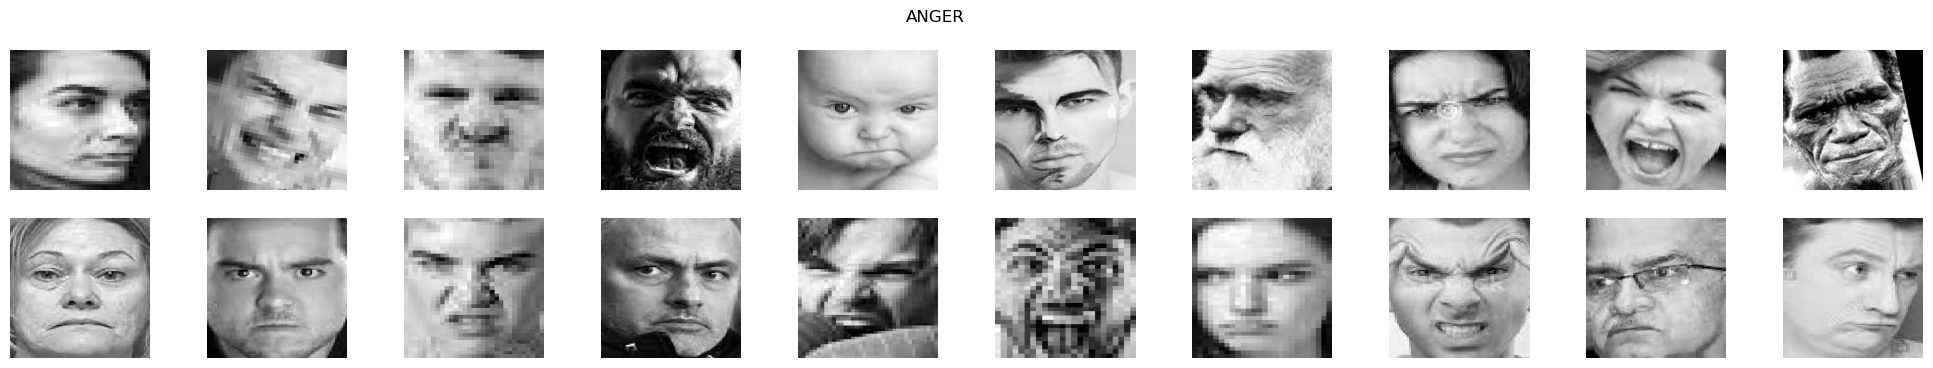

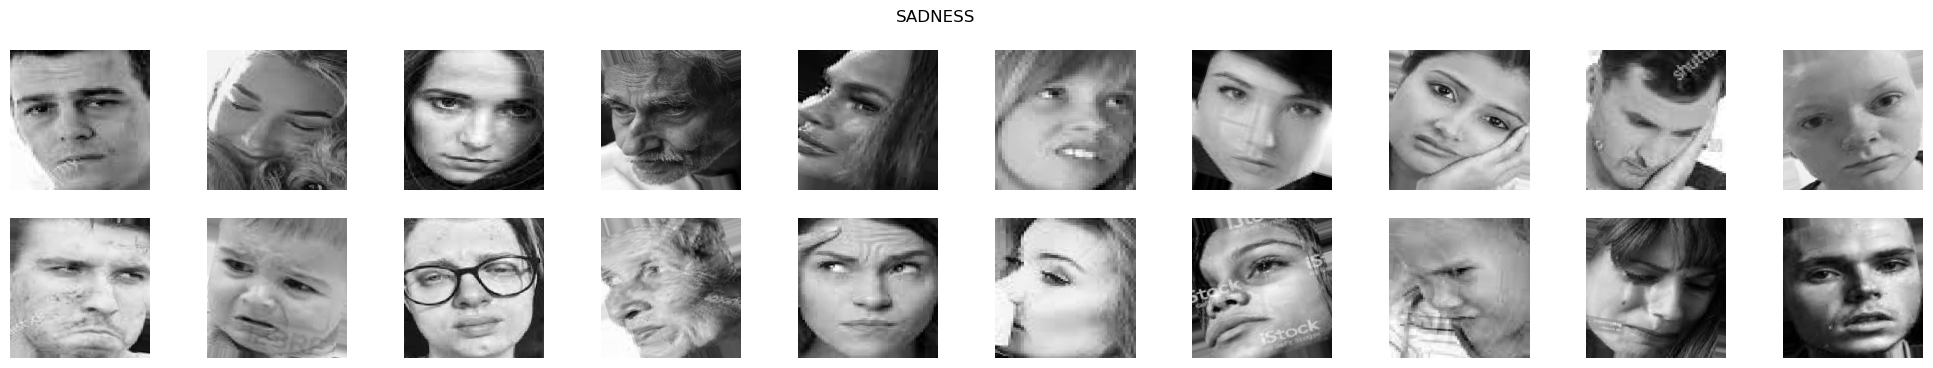

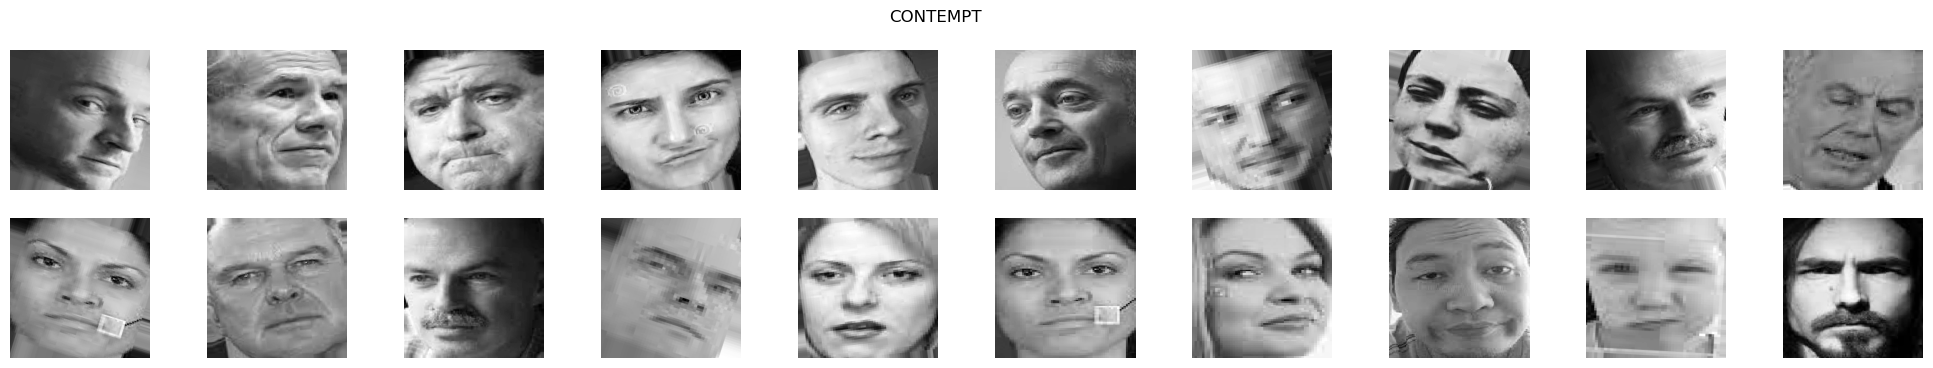

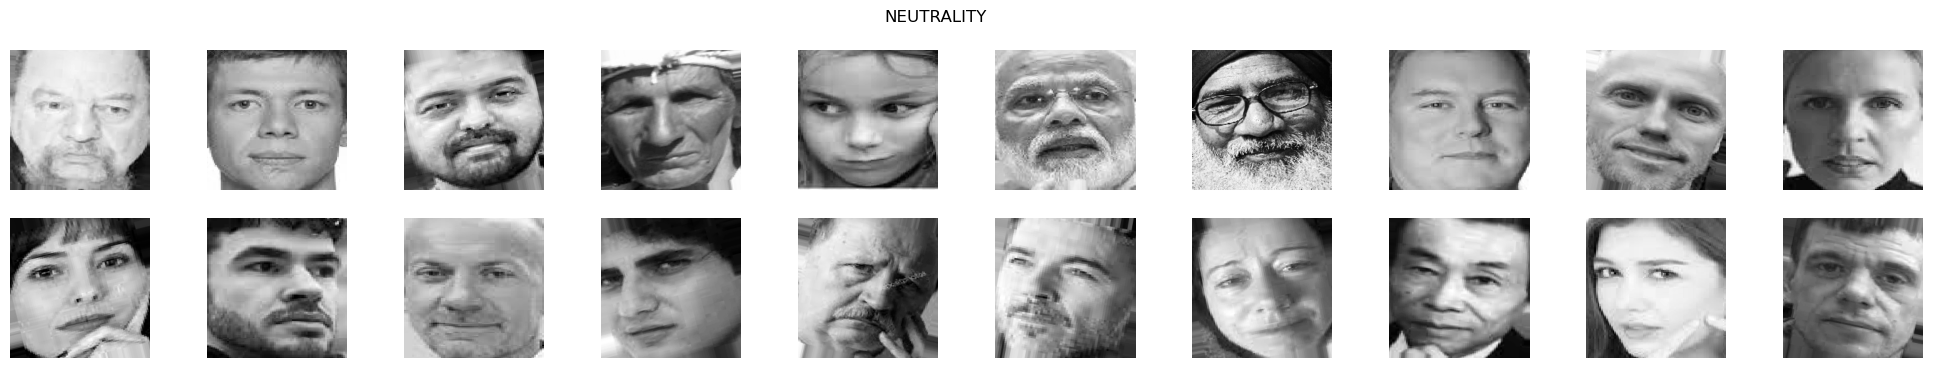

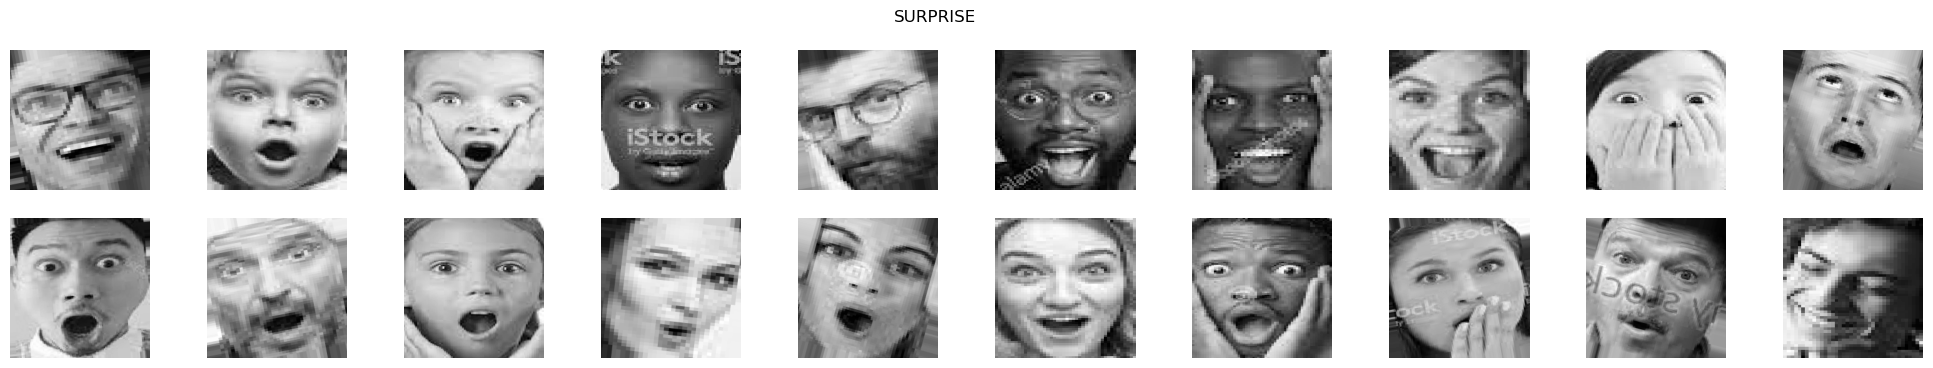

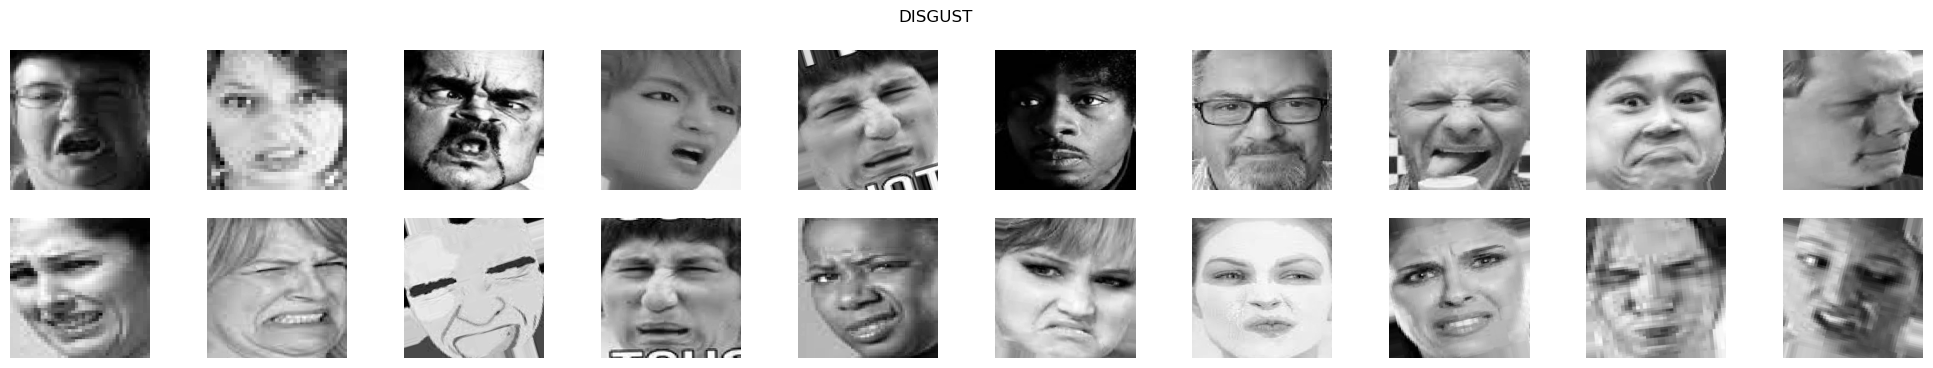

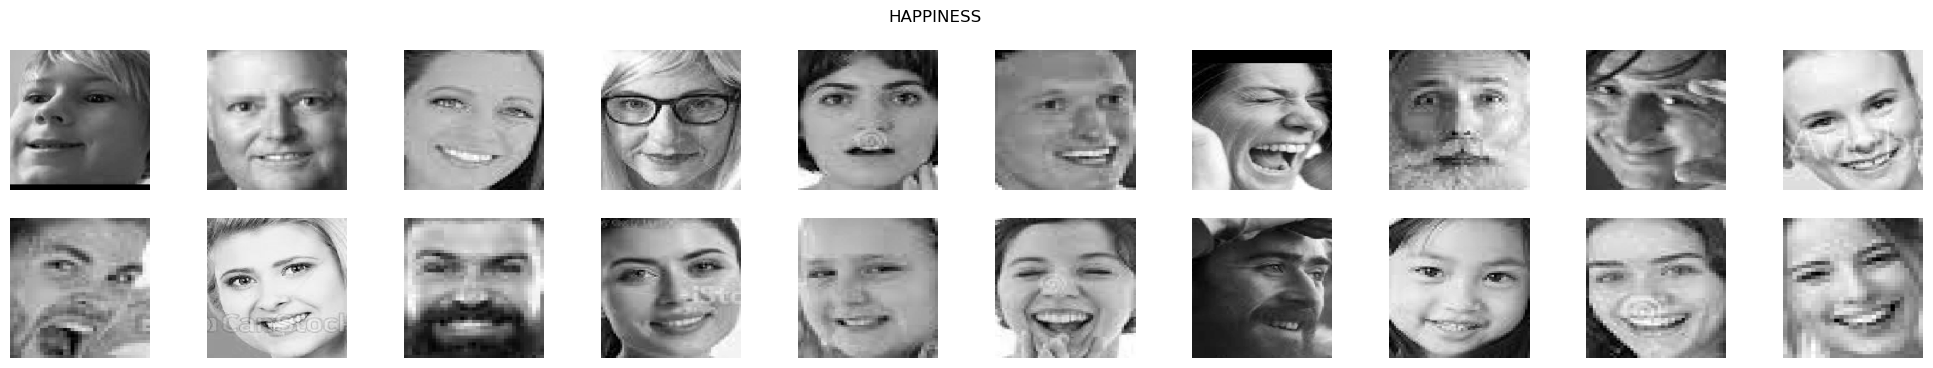

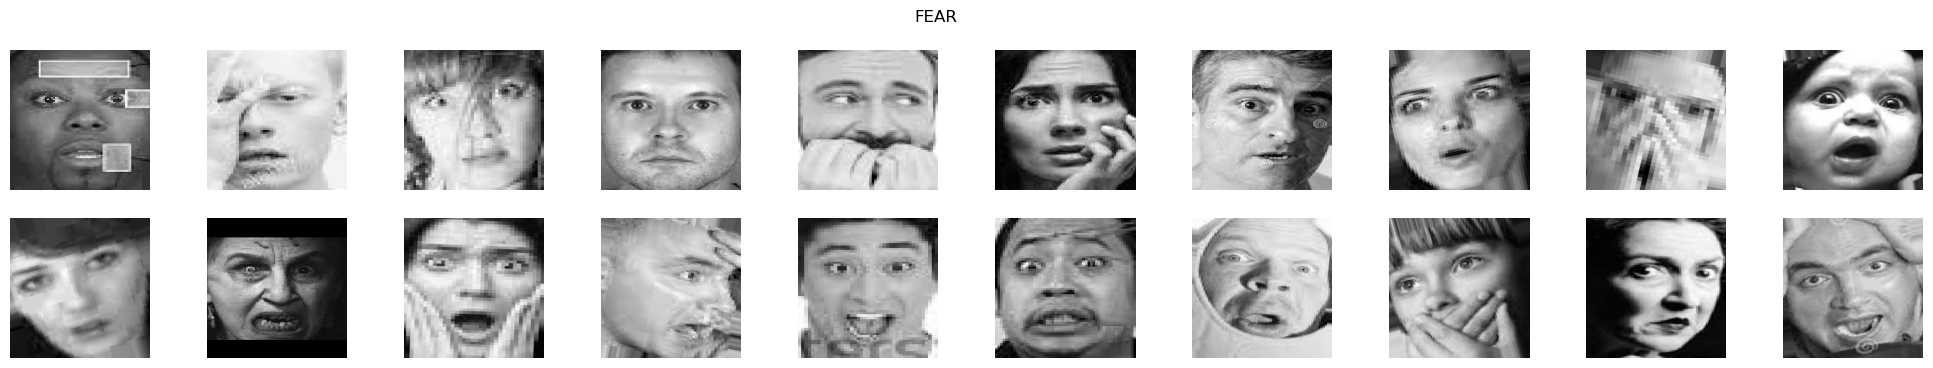

In [16]:
for label in Images:
    images = Images[label]
    class_name = class_names[label]
    f, axs = plt.subplots(2, 10, figsize=(25, 4))
    axs = axs.reshape(-1)
    f.suptitle(class_name.upper())
    for i, image in enumerate(images):
        ax = plt.subplot(2, 10, i + 1)
        axs[i].imshow(image.numpy().astype("uint8"), cmap='gray')
        axs[i].axis("off")    

In [17]:
validation_dataset_cardinality = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_dataset_cardinality // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 139
Number of test batches: 27


In [18]:
# AUTOTUNE = tf.data.AUTOTUNE

train_dataset      = train_dataset.cache().prefetch(buffer_size=BATCH_SIZE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=BATCH_SIZE)
test_dataset       = test_dataset.cache().prefetch(buffer_size=BATCH_SIZE)

# Use data augmentation
ZOOM = (0.0, -0.2)
data_augmentation = tf.keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05, fill_mode='nearest')
        # , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=ZOOM, width_factor=ZOOM)
    ]
)

2022-12-13 10:23:28.930900: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


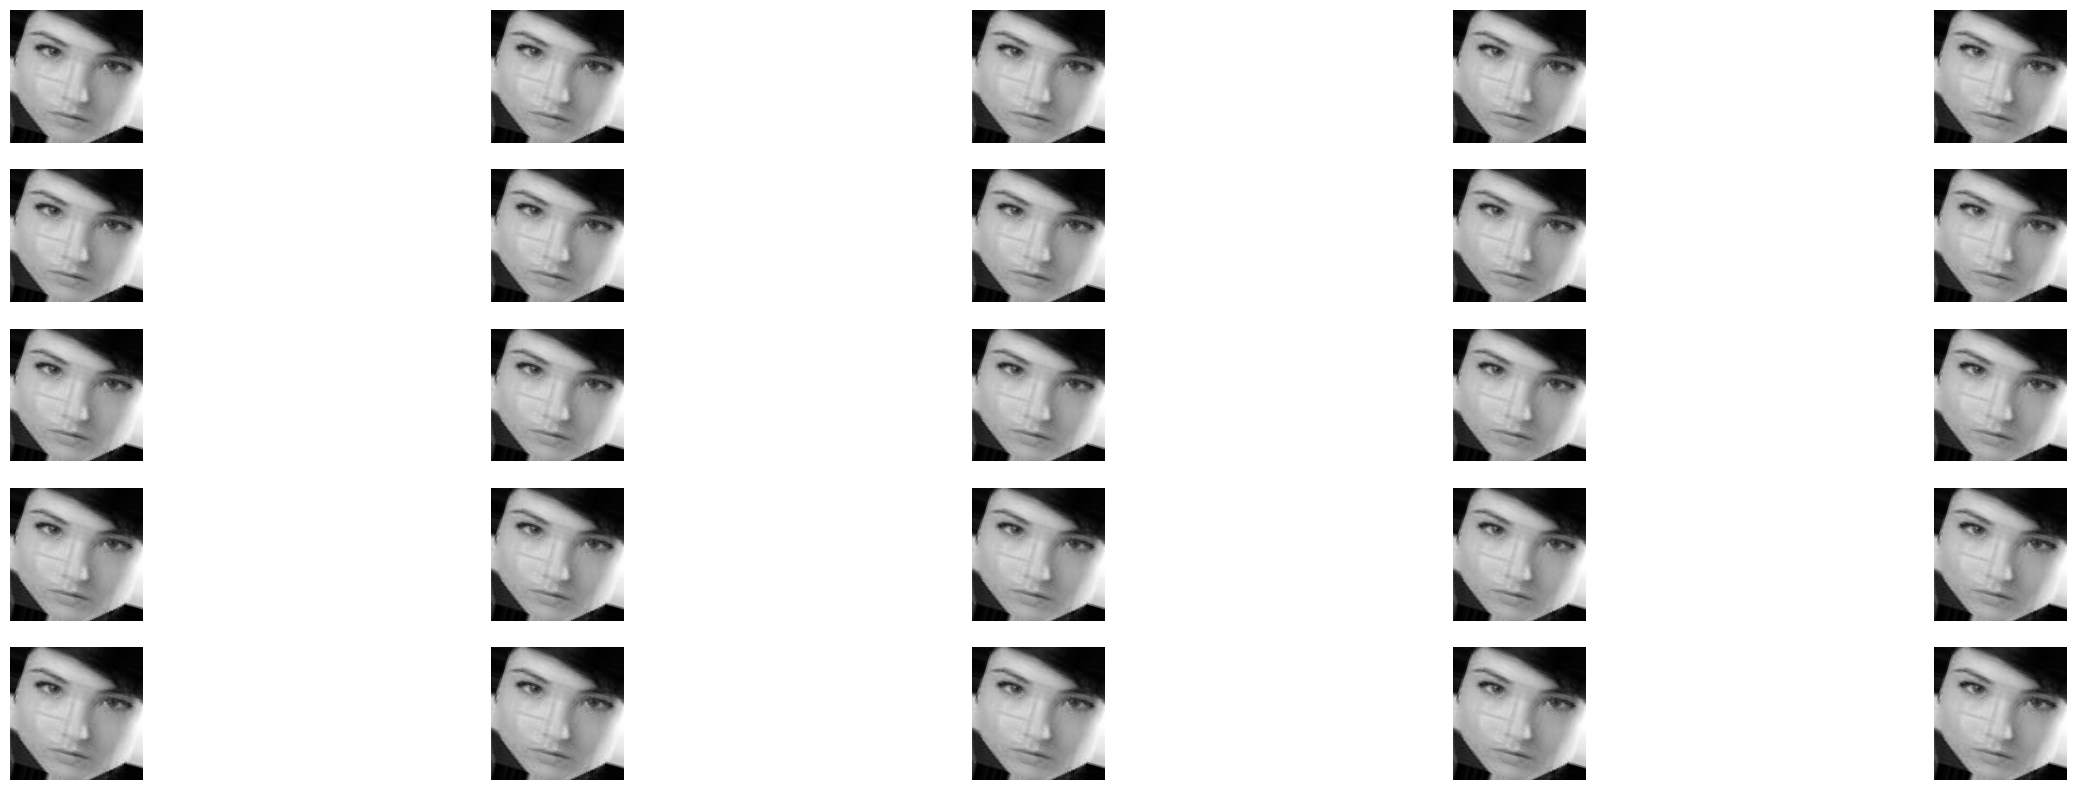

In [19]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(30, 10))
    image = images[0]    
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0].numpy() / 255, cmap='gray')
        plt.axis('off')
plt.show()

In [20]:
model = tf.keras.models.load_model('saved_baseline_model_v1_augmented/model')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 sequential_1 (Sequential)   (None, 8)                 114998    
                                                                 
Total params: 114,998
Trainable params: 114,788
Non-trainable params: 210
_________________________________________________________________


In [21]:
Predictions = []
Labels = []
for image_batch, label_batch in test_dataset:
    predictions = np.argmax(model.predict_on_batch(image_batch), axis=-1)
    Predictions = Predictions + list(predictions)
    Labels = Labels + list(label_batch.numpy())

2022-12-13 10:23:45.680672: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 45.94MiB (rounded to 48168960)requested by op model/sequential_1/CONV01/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-12-13 10:23:45.681329: W tensorflow/core/common_runtime/bfc_allocator.cc:474] ***************************************x**********************************__________________________
2022-12-13 10:23:45.681411: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:684 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[16,15,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
2022-12-13 10:23:45.710623: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not f

ResourceExhaustedError: Graph execution error:

Detected at node 'model/sequential_1/CONV01/Conv2D' defined at (most recent call last):
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 392, in do_execute
      res = shell.run_cell(
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5133/1233179836.py", line 4, in <module>
      predictions = np.argmax(model.predict_on_batch(image_batch), axis=-1)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/training.py", line 2179, in predict_on_batch
      outputs = self.predict_function(iterator)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/training.py", line 1801, in predict_function
      return step_function(self, iterator)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/training.py", line 1790, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/training.py", line 1783, in run_step
      outputs = model.predict_step(data)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/training.py", line 1751, in predict_step
      return self(x, training=False)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model/sequential_1/CONV01/Conv2D'
OOM when allocating tensor with shape[16,15,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/sequential_1/CONV01/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_157603]

In [ ]:
print('{}'.format(list(zip(Predictions, Labels))))

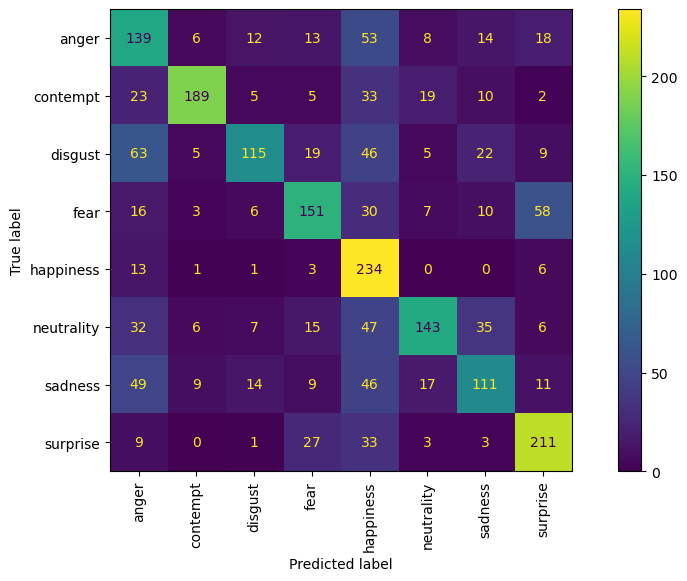

In [22]:
print('Confusion matrix')
cm = confusion_matrix(Labels, Predictions)
print(' '.join('{:<12s}'.format(el) for el in class_names))
for row in cm:
    print(' '.join('{:<12d}'.format(el) for el in row))
print('===')
print('Precision per class')
num = [cm[i,i] for i in range(len(cm))]
den = np.sum(cm, axis=0)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean precision: {:<12.2f}'.format(np.mean(num/den)))
print('===')
print('Recall per class')
num = [cm[i,i] for i in range(len(cm))]
den = np.sum(cm, axis=1)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean recall (balanced accuracy score): {:<12.2f}'.format(np.mean(num/den)))

In [ ]:
ig, ax = plt.subplots(figsize=(20*0.6, 10*0.6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(xticks_rotation='vertical', values_format='d', ax=ax)